# Comparying mean Cross-slope-heat-transport between OM2-01 and Panan-01

Panan-01 and ACCESS-OM2-01 have the same bathymetry and surface forcing. So a comparisson of the Cross-slope-heat-transport between these simulations can help highlight dynamical differences that are purely due to different ocean models

In [1]:
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
from dask.distributed import Client
from scipy.interpolate import interp1d

import xarray as xr
import cf_xarray as cfxr

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44191/status,
Dashboard: /proxy/44191/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33419,Workers: 7
Dashboard: /proxy/44191/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:36067,Total threads: 4
Dashboard: /proxy/42895/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:41849,


In [146]:
#panan01 daily as f(z,time)
src_p01 = '/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/Processed_data/panan01/CSHT_daily_z/*'
#OM2 as f(time), vertically integrated
src_OM2 = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v13_ryf9091/Ant_cross_slope_heat_terms_online_1000m_2095*'



In [74]:
#importing panan01
import glob
gl =glob.glob(src_p01)
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
panan_HT=xr.open_mfdataset(gl, concat_dim='time', combine='nested').rename({'zl':'z_l'})

12 netcdf data files


In [147]:
gl =glob.glob(src_OM2)
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
OM2_HT=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

12 netcdf data files


#### Vertically integrating panan01

In [38]:
session = cc.database.create_session()
exp_panan01 = 'panant-01-zstar-ACCESSyr2'

tvol_p01 = cc.querying.getvar(exp_panan01,'volcello',session,start_time='2000-01',
                              end_time='2001-01',frequency = '1 daily',
                              attrs={'cell_methods' : 'area:sum z_l:sum yh:sum xh:sum time: mean'} )
tvol_p01 = tvol_p01.isel(z_l=slice(0,51))

In [72]:

tvol_01_unbinned = tvol_p01.sel(xh=panan_HT.lon_along_contour,yh=panan_HT.lat_along_contour,method='nearest')
tvol_01_binned = tvol_p01.sel(xh=panan_HT.lon_bin_midpoints,yh=panan_HT.lat_bin_midpoints,method='nearest')


In [160]:
P01_unbinned_HT=panan_HT.unbinned_heat_transp_across_contour.sum('z_l')
P01_binned_CSHT=panan_HT.binned_cross_slope_heat_trans.sum('z_l')
P01_binned_ZC=panan_HT.zonal_convergence.sum('z_l')

In [156]:
# #unbinned heat transport
# P01_unbinned_HT=(panan_HT.unbinned_heat_transp_across_contour*tvol_01_unbinned).sum('z_l')/tvol_01_unbinned.sum('z_l')
# #cross slope heat transport binned
# P01_binned_CSHT=(panan_HT.binned_cross_slope_heat_trans*tvol_01_binned).sum('z_l')/tvol_01_binned.sum('z_l')
# #binned zonal covnergence
# P01_binned_ZC=(panan_HT.zonal_convergence*tvol_01_binned).sum('z_l')/tvol_01_binned.sum('z_l')

## 1 - Spatial differences and total CSHT

In [94]:
figdir='/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/figs/'

In [161]:
P01_unbinned_HT_mean=P01_unbinned_HT.groupby('time.month').mean('time').mean('month').load()
OM2_unbinned_HT_mean=OM2_HT.heat_trans_across_contour.mean('time').load()

In [169]:
P01_binned_CSHT_mean=P01_binned_CSHT.groupby('time.month').mean('time').mean('month').load()
OM2_binned_CSHT_mean=OM2_HT.cross_slope_heat_trans.mean('time').load()

In [171]:
P01_binned_ZC_mean=P01_binned_ZC.groupby('time.month').mean('time').mean('month').load()
OM2_binned_ZC_mean=OM2_HT.zonal_convergence.mean('time').load()

In [ ]:
P01_factor=

In [166]:
P01_unbinned_lon=panan_HT.isel(time=0).lon_along_contour
OM2_unbinned_lon=OM2_HT.isel(time=0).lon_along_contour
P01_binned_lon=panan_HT.isel(time=0).lon_bin_midpoints
OM2_binned_lon=OM2_HT.isel(time=0).lon_bin_midpoints

In [174]:
panan_factor=P01_unbinned_HT_mean.sum()/(P01_binned_CSHT_mean+P01_binned_ZC_mean).sum()
OM2_factor=OM2_unbinned_HT_mean.sum()/(OM2_binned_CSHT_mean+OM2_binned_ZC_mean).sum()

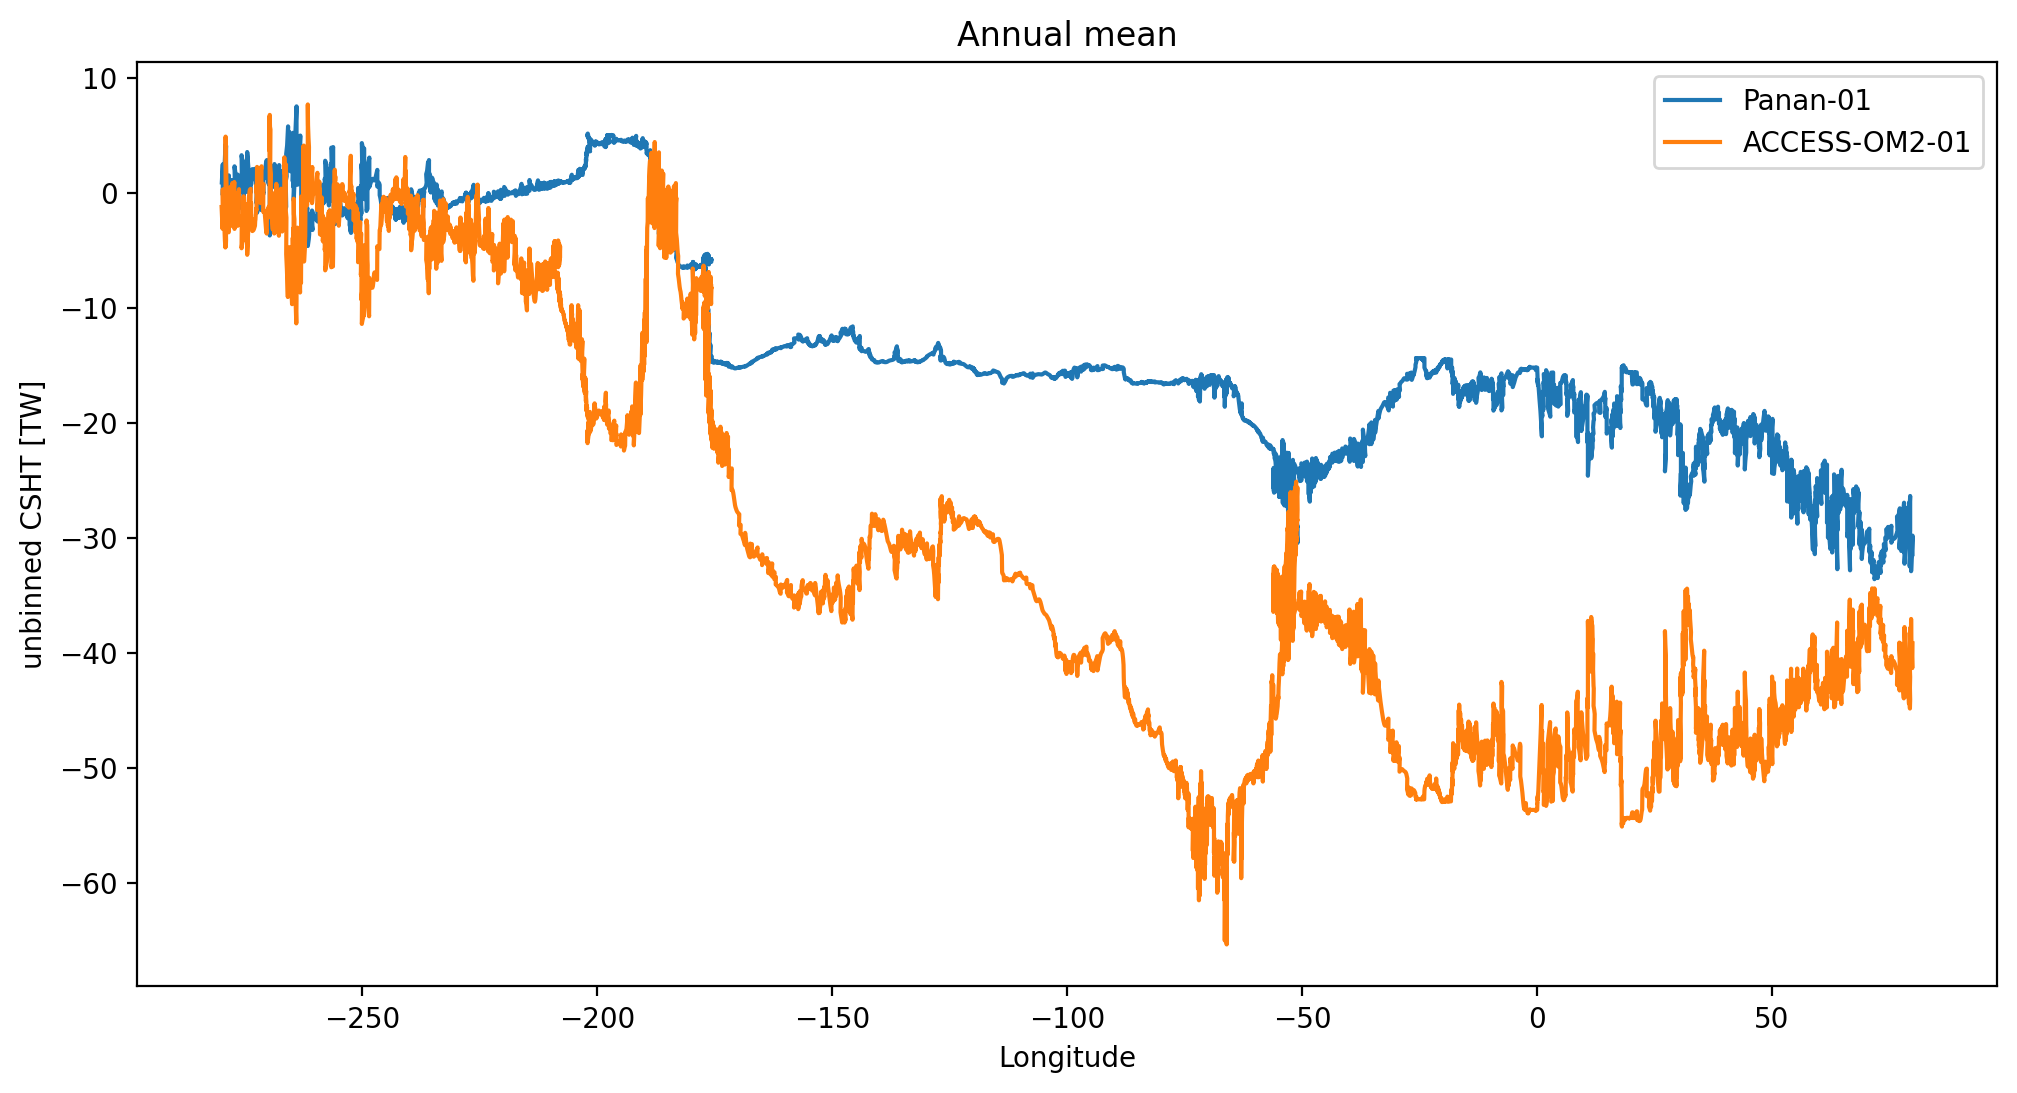

In [186]:
fig = plt.figure(figsize=(12,6))

plt.plot(P01_unbinned_lon,P01_unbinned_HT_mean.cumsum()/1e12,label='Panan-01')
plt.plot(OM2_unbinned_lon,OM2_unbinned_HT_mean.cumsum()/1e12,label='ACCESS-OM2-01')
plt.xlabel('Longitude'); plt.ylabel('unbinned CSHT [TW]'); plt.title('Annual mean')
plt.legend()

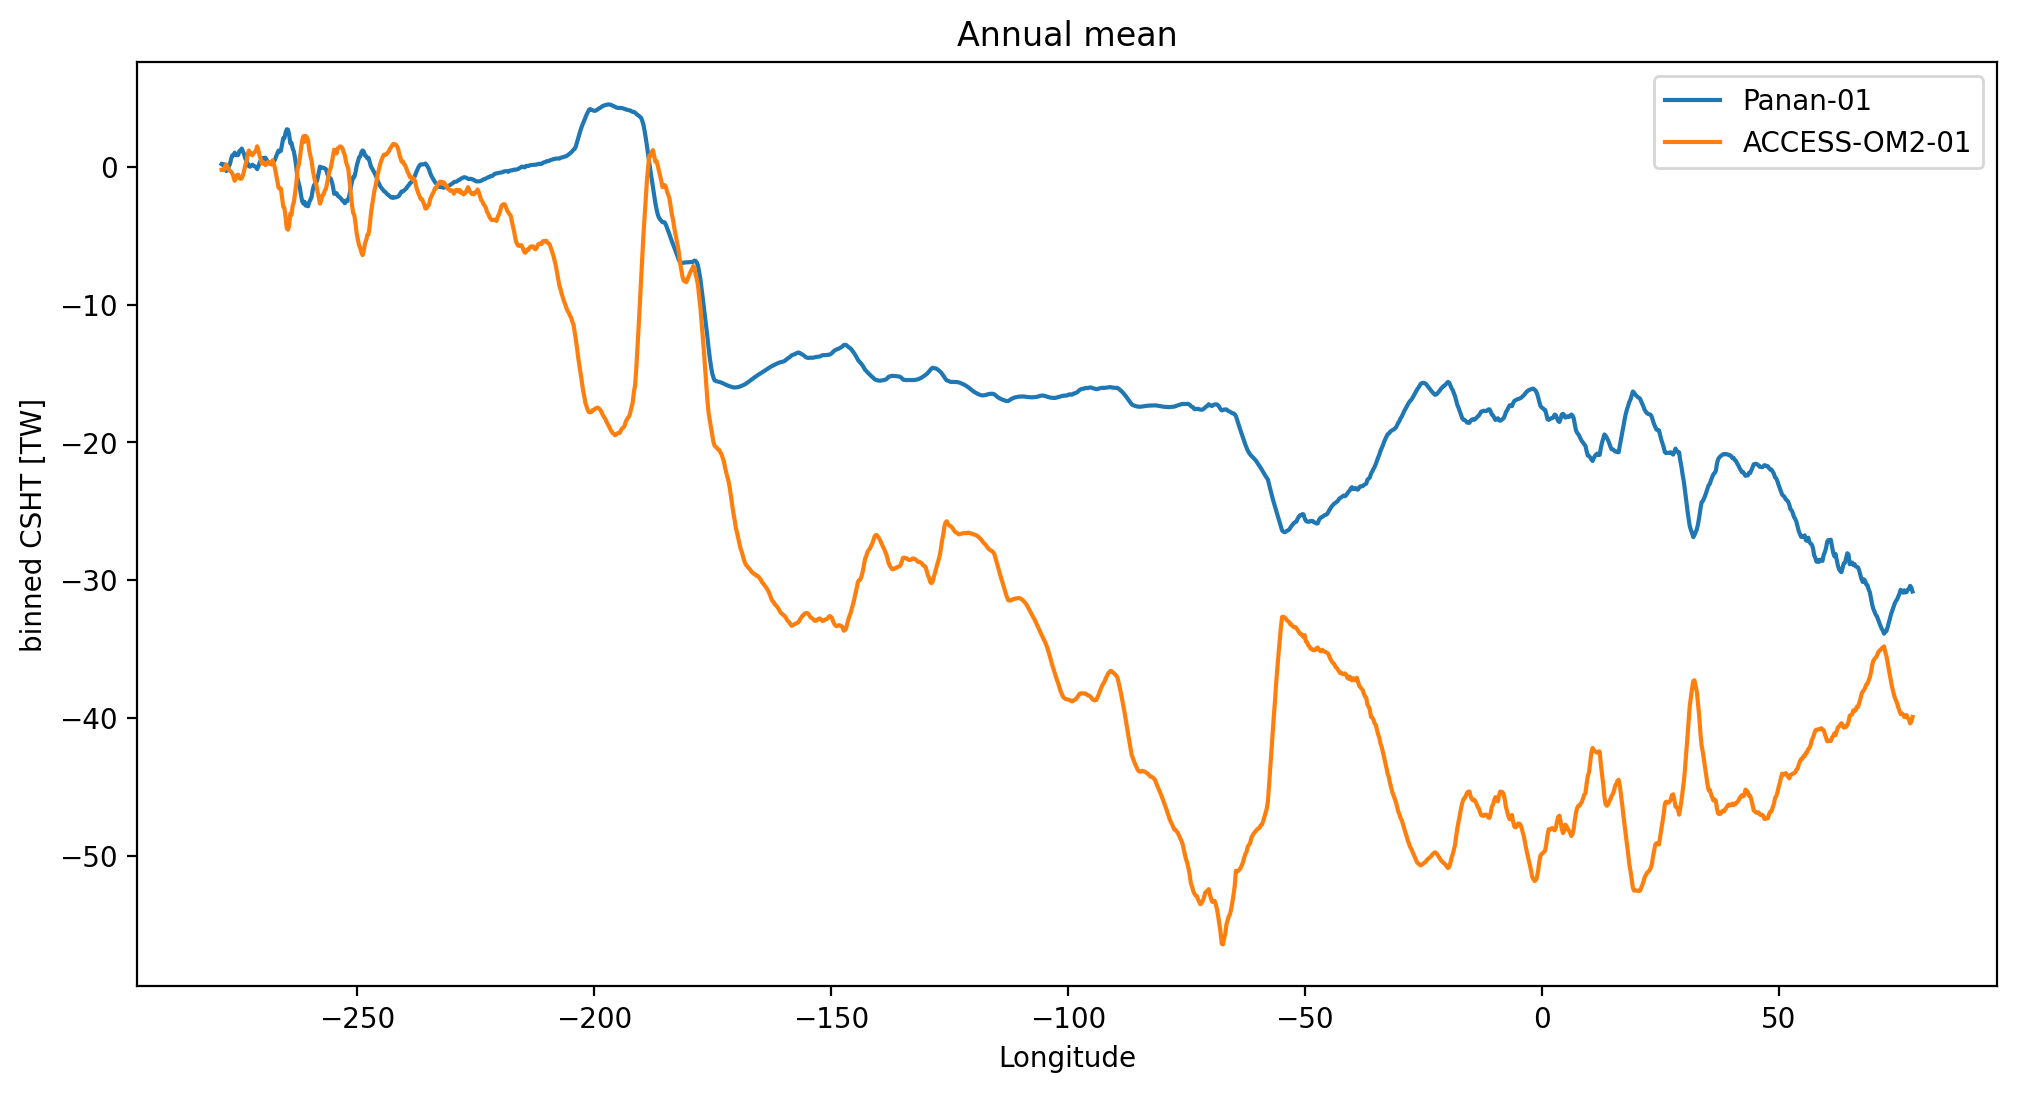

In [187]:
fig = plt.figure(figsize=(12,6))

plt.plot(P01_binned_lon,P01_binned_CSHT_mean.cumsum()*panan_factor/1e12,label='Panan-01')
plt.plot(OM2_binned_lon,OM2_binned_CSHT_mean.cumsum()*OM2_factor/1e12,label='ACCESS-OM2-01')
plt.xlabel('Longitude'); plt.ylabel('binned CSHT [TW]'); plt.title('Annual mean')
plt.legend()

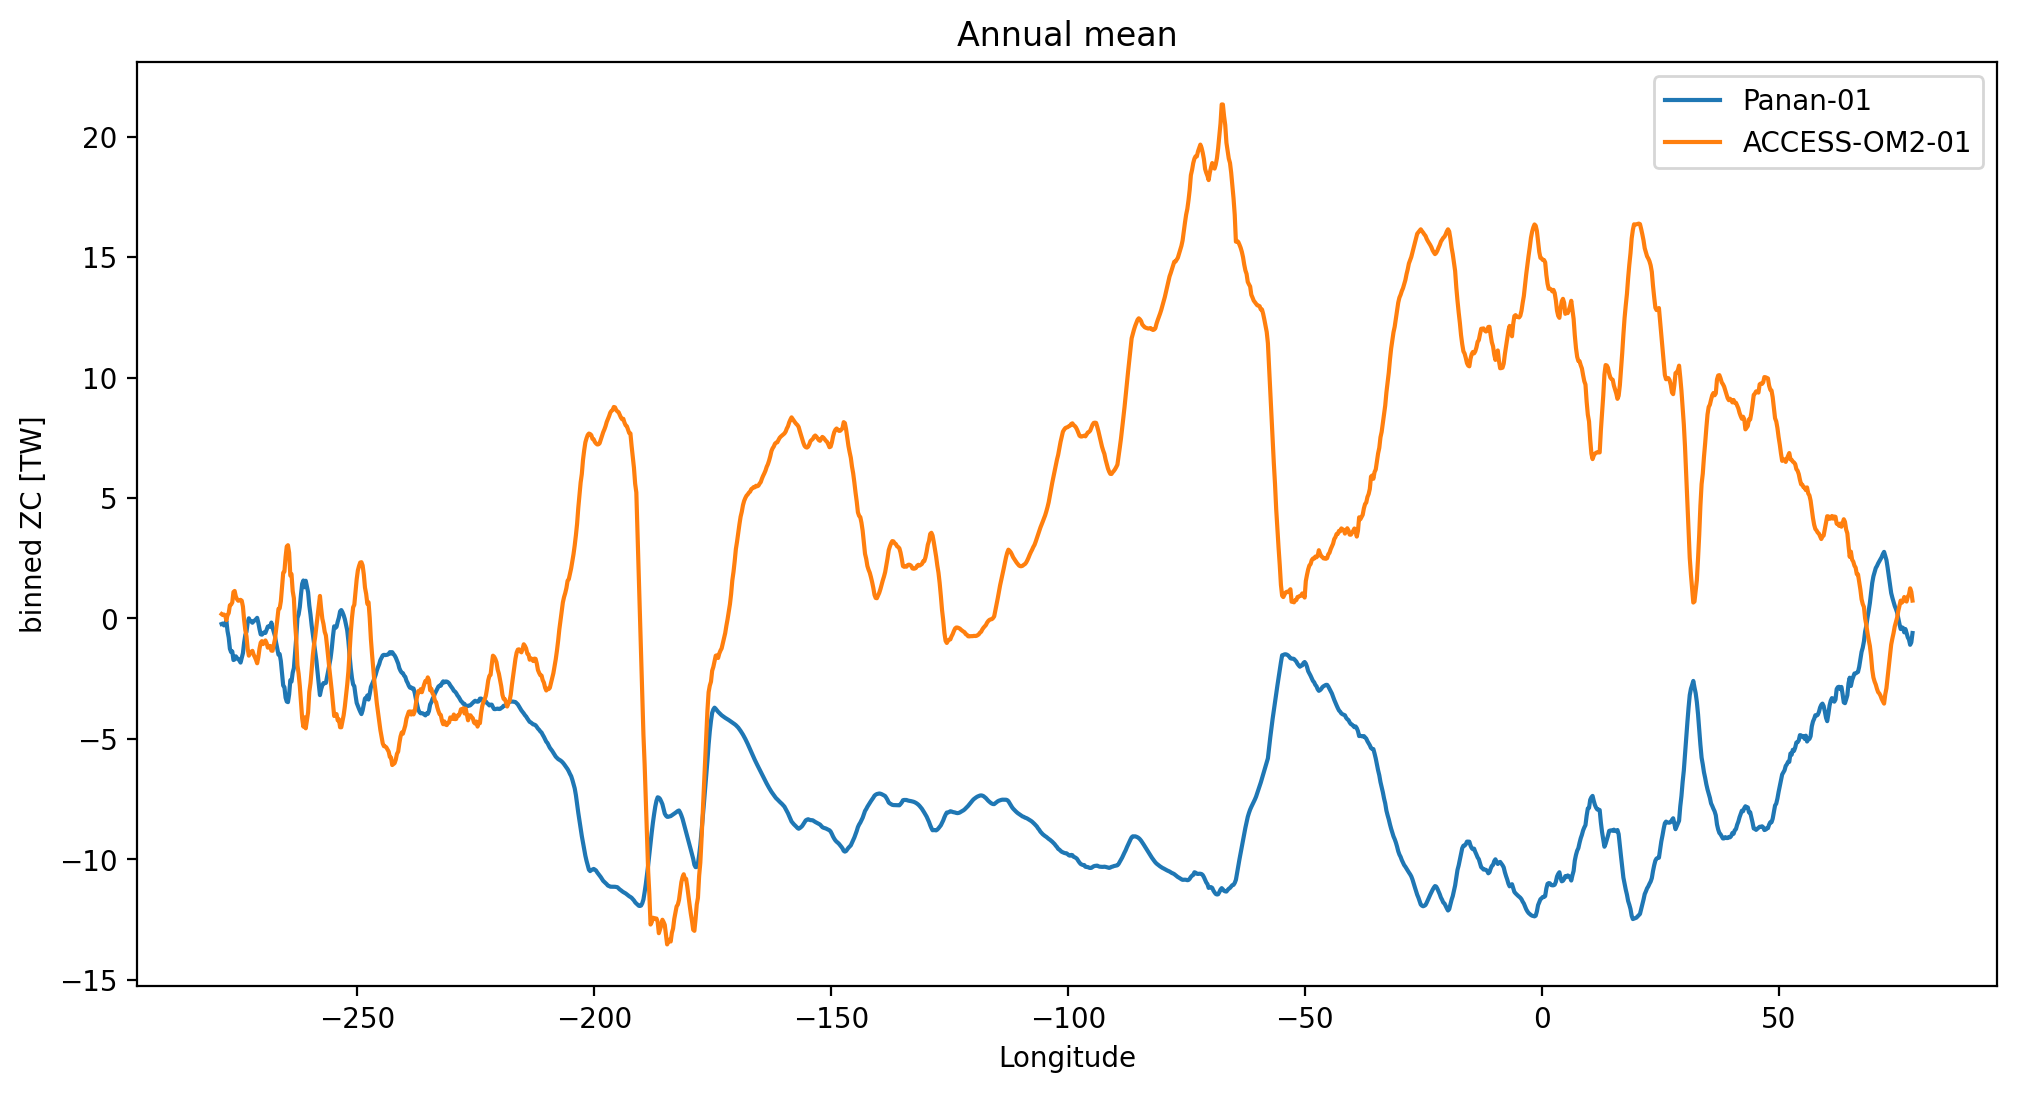

In [188]:
fig = plt.figure(figsize=(12,6))

plt.plot(P01_binned_lon,P01_binned_ZC_mean.cumsum()*panan_factor/1e12,label='Panan-01')
plt.plot(OM2_binned_lon,OM2_binned_ZC_mean.cumsum()*OM2_factor/1e12,label='ACCESS-OM2-01')
plt.xlabel('Longitude'); plt.ylabel('binned ZC [TW]'); plt.title('Annual mean')
plt.legend()

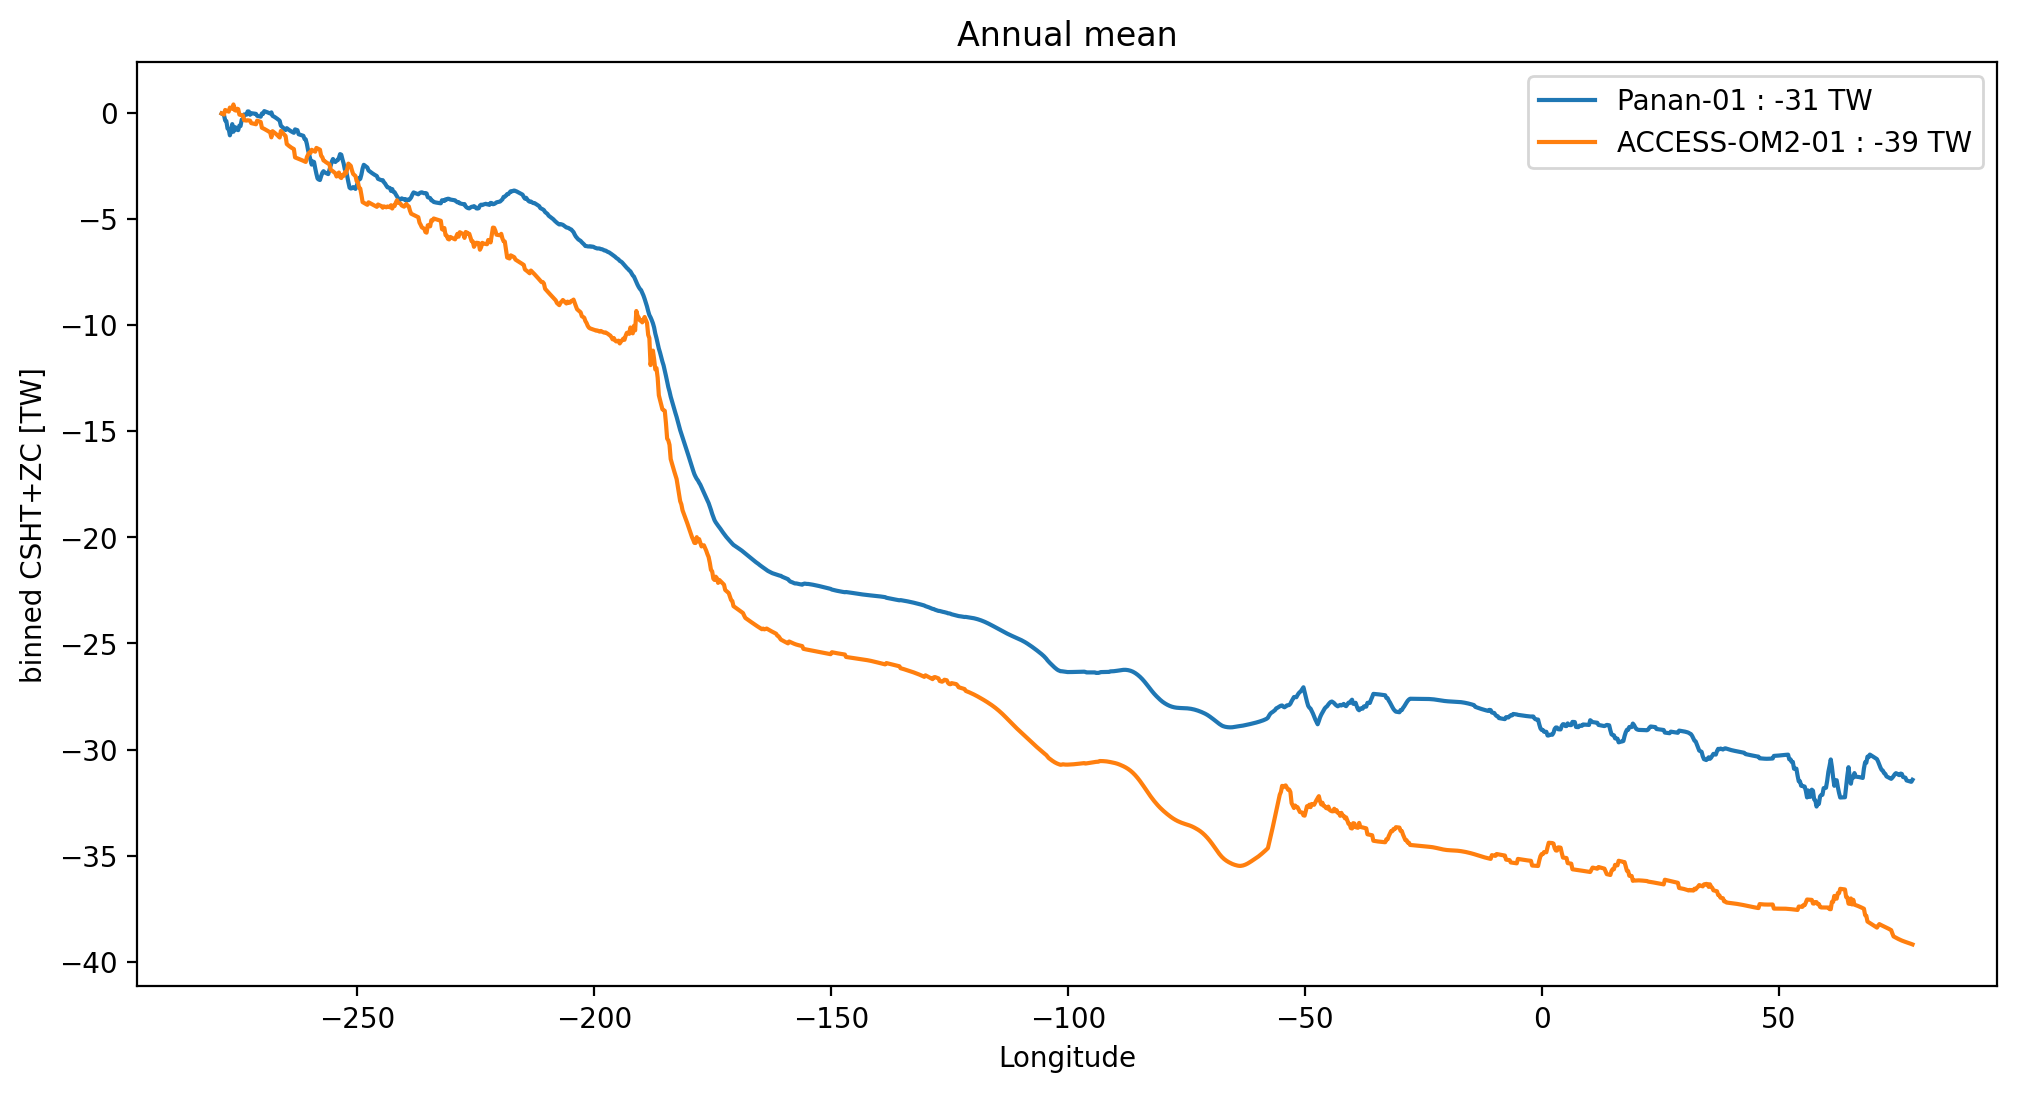

In [189]:
Ptotal=str(int((P01_binned_CSHT_mean+P01_binned_ZC_mean).sum()*panan_factor/1e12))
OM2total = str(int((OM2_binned_CSHT_mean+OM2_binned_ZC_mean).sum()*OM2_factor/1e12))

fig = plt.figure(figsize=(12,6))

plt.plot(P01_binned_lon,(P01_binned_CSHT_mean+P01_binned_ZC_mean).cumsum()*panan_factor/1e12,label='Panan-01 : '+Ptotal + ' TW')
plt.plot(OM2_binned_lon,(OM2_binned_CSHT_mean+OM2_binned_ZC_mean).cumsum()*OM2_factor/1e12,label='ACCESS-OM2-01 : ' +OM2total + ' TW')
plt.xlabel('Longitude'); plt.ylabel('binned CSHT+ZC [TW]'); plt.title('Annual mean')
plt.legend()

##### 1.1: Summary:

We can see that most of the differences in the unbinned HT are compensated by the zonal convergence. In the end, the total CSHT+ZC curves are fairly similar. a few points to think about:


[a]  - Why is the zonal convergence so different between the simulations? on OM2 the zonal convergence seem to oscillate much more along the contour than on panan. Does that mean that ASC representation differs substantially between simulations?

[b] Although the total CSHT calculated for the simulations seem similar, they differ by 8 TW, or ~20%. ANd that should be purely due to different ocean/sea-ice models, since both simulations have same forcing and bathymetry. 

[c] - WHen we see the CSHT values for the IAF simulation of ACCESS-OM2-01, we see that they oscillate up to -120 TW. The years that are used to force the RYF simulations are just years with particularly low ocillations in the CSHT. We should keep that in mind when analyzing our results! See the case of total CSHT in ACCESS-OM2-01 below for reference. ![Check figure below](https://github.com/willaguiar/ASC_and_heat_transport/blob/main/figs/CSHT_IAF.png?raw=true) 



## 2 - Timeseries differences

In [197]:
P01_unbinned_HT_monthly=P01_unbinned_HT.groupby('time.month').mean('time').sum('contour_index').load()
OM2_unbinned_HT_monthly=OM2_HT.heat_trans_across_contour.sum('lon_along_contour').load()

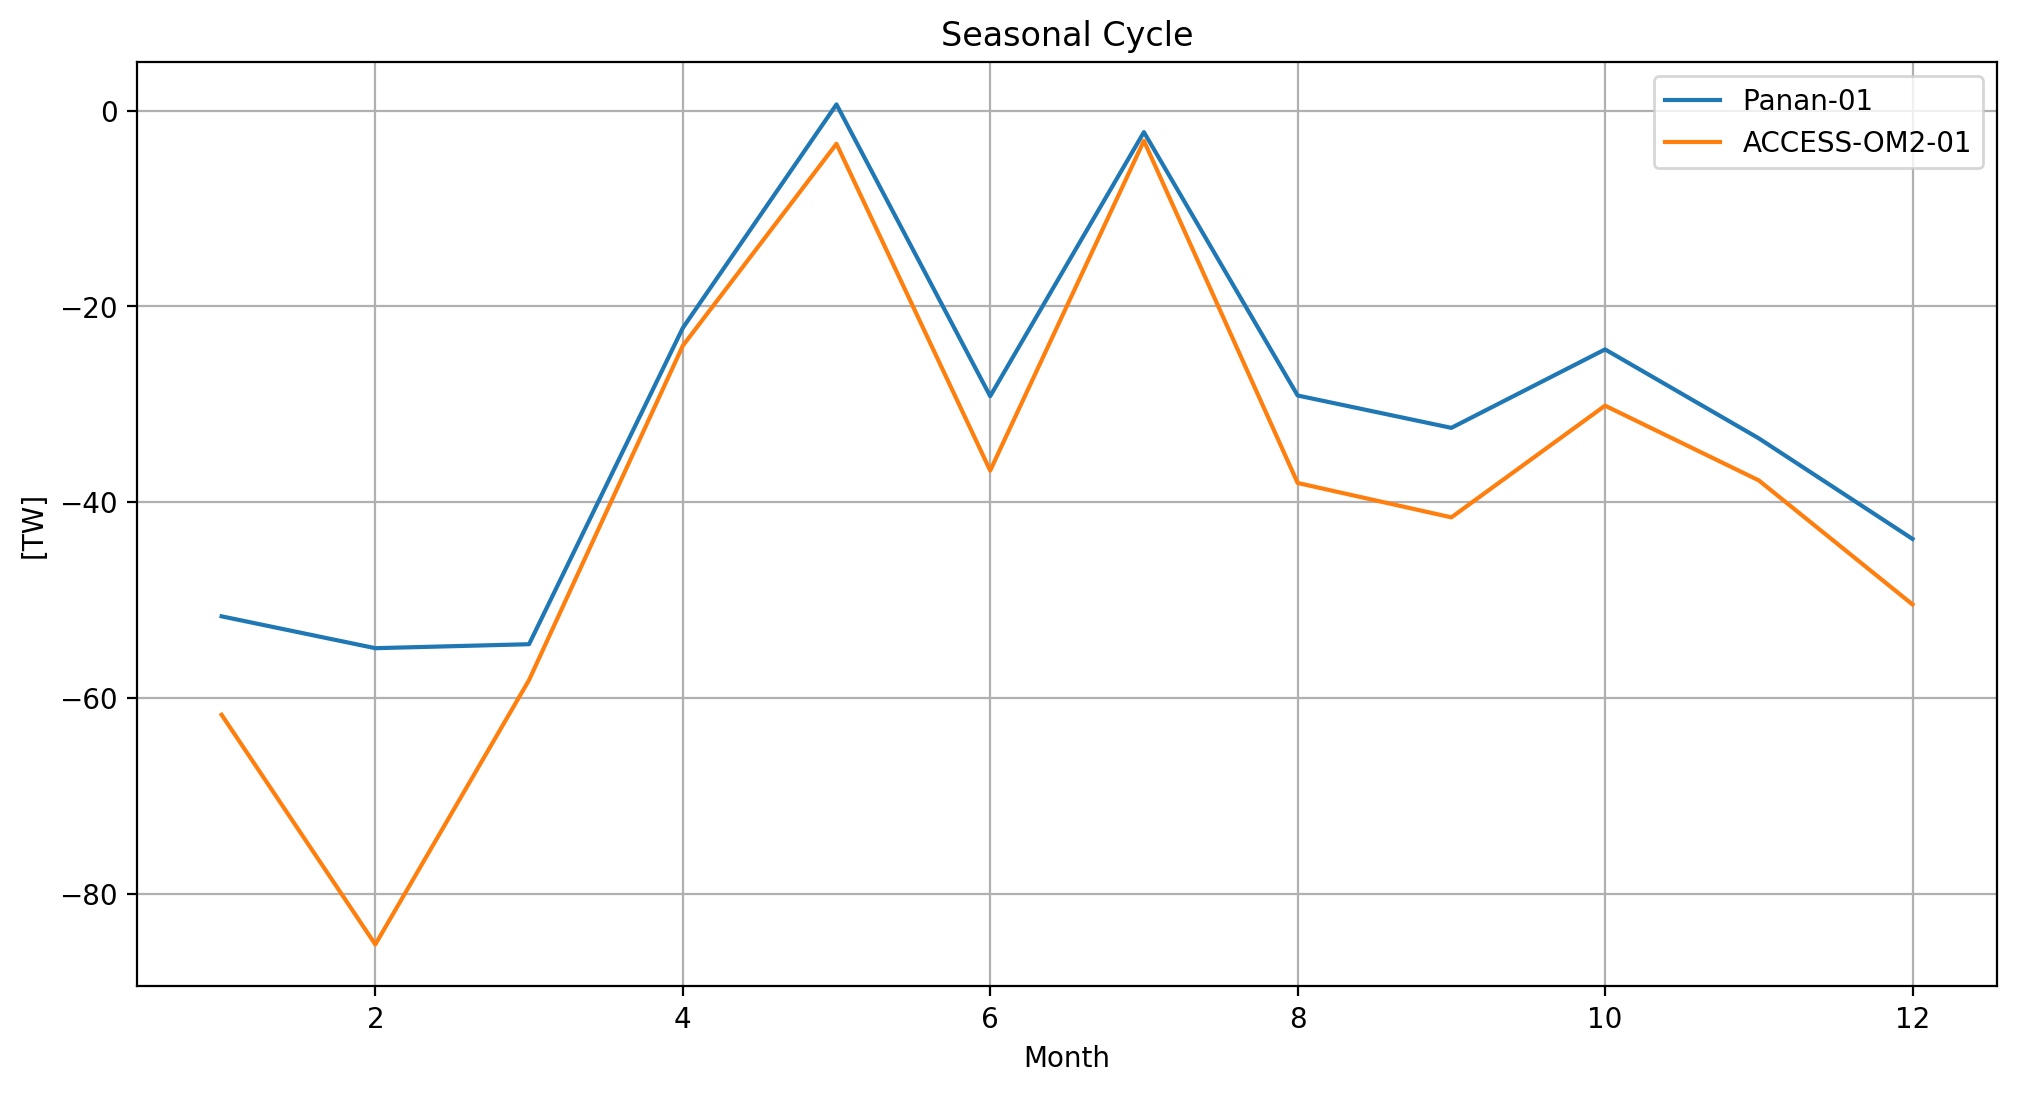

In [203]:
fig = plt.figure(figsize=(12,6))

plt.plot(np.arange(1,13),P01_unbinned_HT_monthly/1e12,label='Panan-01 ')
plt.plot(np.arange(1,13),OM2_unbinned_HT_monthly/1e12,label='ACCESS-OM2-01')
plt.xlabel('Month'); plt.ylabel('[TW]'); plt.title('Seasonal Cycle')
plt.grid()
plt.legend()

We have very similar seasonalyty between both models, except by the maximum summer transport present in OM2 in February, but not in panan01